<a href="https://colab.research.google.com/github/ebercab7/fcomputacional/blob/main/Evaluaci%C3%B3n1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Evaluación 1: Analisis de Series de Tiempo**

Analisis a los datos de concentración de CO2 en la atmosfera terrestre.

# **Bibliotecas a utilizar y preparación de los datos**

In [183]:
# Actividad 6: Pronostico de series de tiempo
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm
# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline 

In [184]:
# Se define el url donde estan los datos para convertirlo en dataframe:
url ="https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_spo_DailyData.txt"

# Se da nombre a las columnas del dataframe
columnas = ["Codigo", "Año", "Mes", "Dia", "Hora", "Minuto", "Segundo", "Fecha", "CO2", "CO2_std_dev", "ValorN", "Latitud", "Longitud", "Altitud", "Elevación", "Intake_Heith", "qcflag"]

# Se lee el dataframe
df_datos = pd.read_csv(url, names=columnas, sep="\s+", header=None, skiprows=151, engine="python")
#df_datos
#df_datos.info()

# Se reemplazan los valores nulos (en este df aquellos iguales a -999.99) por NaN
str_Nulo = -999.99
df_datos1 = df_datos.replace(to_replace=str_Nulo, value="", regex=True)

# Se añande la fecha en un formato de utilidad
df_fecha = pd.DataFrame({"day":df_datos1["Dia"], "month":df_datos1["Mes"], "year":df_datos1["Año"]})
df_datos1["Fecha"] = pd.to_datetime(df_fecha).copy()

# Se indica que el indice será la fecha
df_datos1 = df_datos1.set_index("Fecha")

# Se toma la columna de interes y se le da formato numerico a la columna CO2 (cuando quitmaos los nulos paso a objeto)
df_datos1["CO2"] = pd.to_numeric(df_datos1["CO2"], errors="coerce")
ts_test = df_datos1.loc["1980-01-01":"2019-12-31", "CO2"]


# Quitando valores nulos
ts_test.ffill(axis = 0, inplace=True)
ts_test.isnull().sum()

0

# **Analisis de la Serie de Tiempo**

In [185]:
# Se definirá una función que probará la estacionaridad de la serie de tiempo y nos mostrará graficamente la situación
def prueba_est(df_e):
  # Se obtendrá la estadistica de promedios moviles
  prom_mean=df_e.rolling(window=365, center=True).mean()
  prom_estad=df_e.rolling(window=365, center=True).std()

  # Opciones de la figura
  plt.rcParams["figure.figsize"] = (12,6)

  # Graficando la información (prom moviles, estadisticas y promedios)
  plt.plot(df_e, color="blue", label="Datos Diarios")
  plt.plot(prom_mean, color="red", label="Promedio Movil 365 Días")
  plt.plot(prom_estad, color="black", label="Desviación Estándar del Prom Movil")

  plt.legend(loc="best")
  plt.title("Promedio Móvil y Desviación Estándar")
  plt.grid()
  plt.show()
  
  # Se realiza la prueba aumentada de Dickey-Fuller:
  print("Resultados de la Prueba de Dickey-Fuller")
  df_test=adfuller(df_e, autolag="AIC")
  df_out=pd.Series(df_test[0:4], index=["Test Estadistco", "p-value", "#Lag's usados", "Número de observaciones usadas"])
  for key,value in df_test[4].items():
    df_out["Critical Value (%s)"%key] = value
  print(df_out)

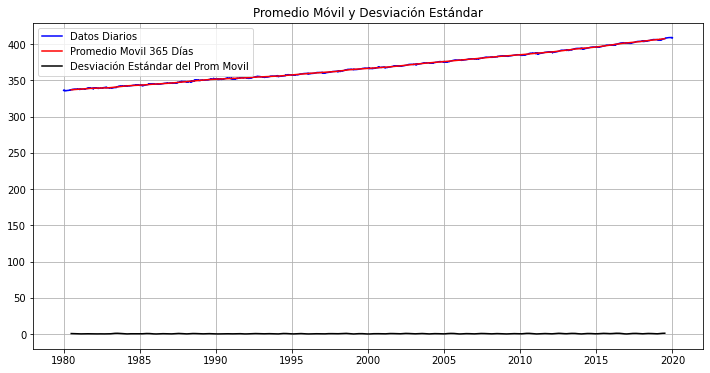

Resultados de la Prueba de Dickey-Fuller
Test Estadistco                       0.973933
p-value                               0.993983
#Lag's usados                        42.000000
Número de observaciones usadas    14567.000000
Critical Value (1%)                  -3.430799
Critical Value (5%)                  -2.861738
Critical Value (10%)                 -2.566876
dtype: float64


In [186]:
# Con la función definida, se prueba la estacionaridad de nuestra serie:
prueba_est(ts_test)


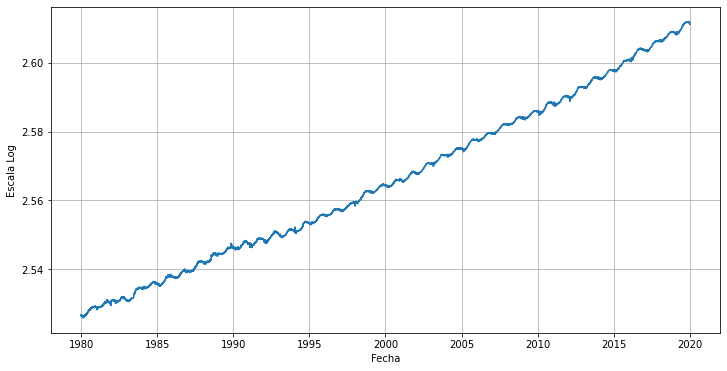

In [187]:
# Se observa que no es estacionaria, tratemos cambiando a escala logaritmica:
ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log);
plt.grid()
plt.ylabel("Escala Log")
plt.xlabel("Fecha");


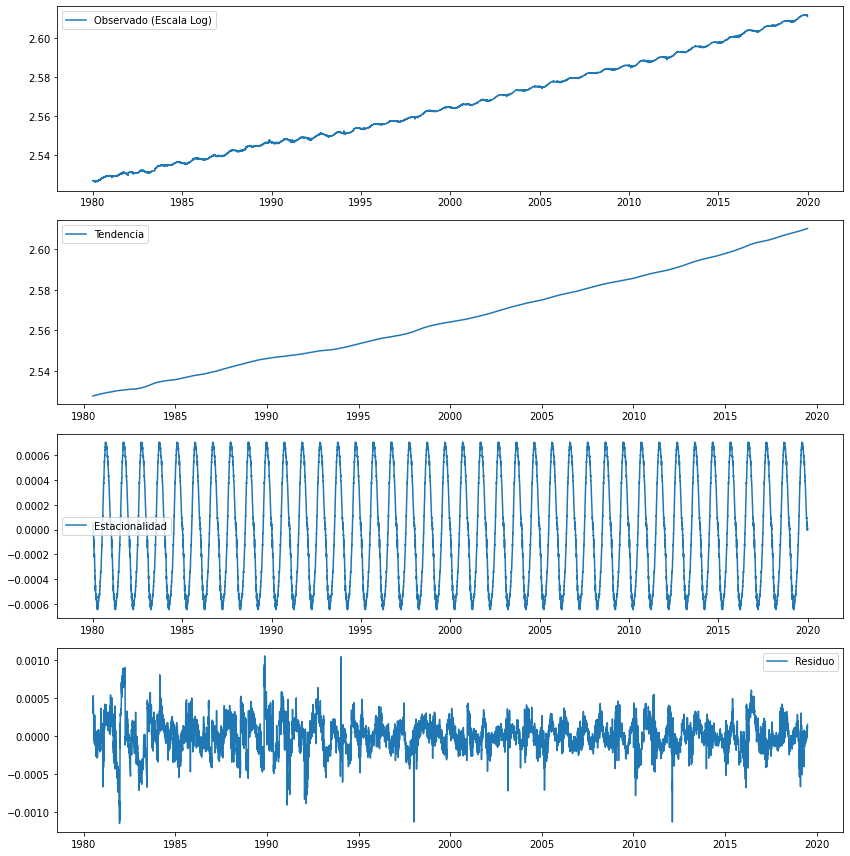

In [188]:
# Se aplica ahora una descomposición a esta serie en escala log
decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

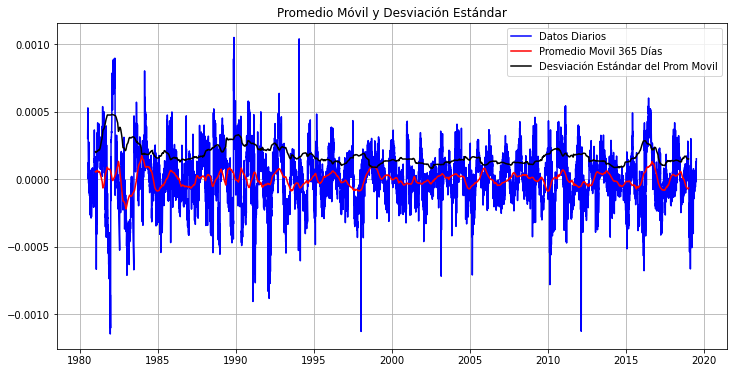

Resultados de la Prueba de Dickey-Fuller
Test Estadistco                  -1.135572e+01
p-value                           9.746288e-21
#Lag's usados                     2.800000e+01
Número de observaciones usadas    1.421700e+04
Critical Value (1%)              -3.430810e+00
Critical Value (5%)              -2.861743e+00
Critical Value (10%)             -2.566878e+00
dtype: float64


In [189]:
# Se observa en la tendencia un comportamiento lineal. Al ser una escala logaritmica
# esto significa que el CO2 tiene un aumento exponencial.
# Si se presta atención a la estacionalidad se nota que los valores más bajos son a principios de año y los más altos a mediados. 
# Para el residuio:

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
prueba_est(ts_test_log_decompose)


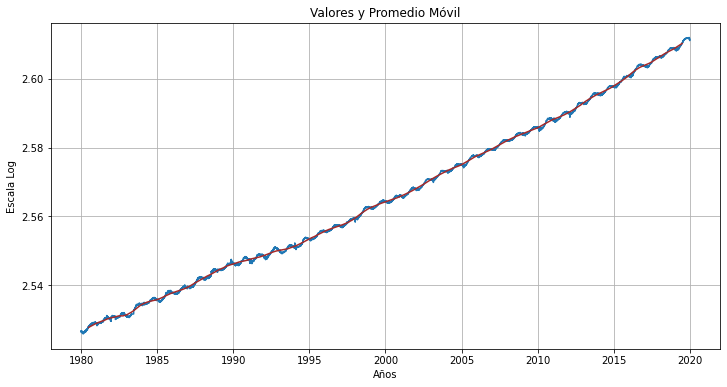

In [190]:
# Como se ve, el residuo es estacionario.
# Ahora veamos los promedios moviles.

prom = ts_test_log.rolling(365, center=True).mean()

plt.plot(ts_test_log)
plt.plot(prom, color = 'brown')
plt.xlabel('Años')
plt.ylabel('Escala Log')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

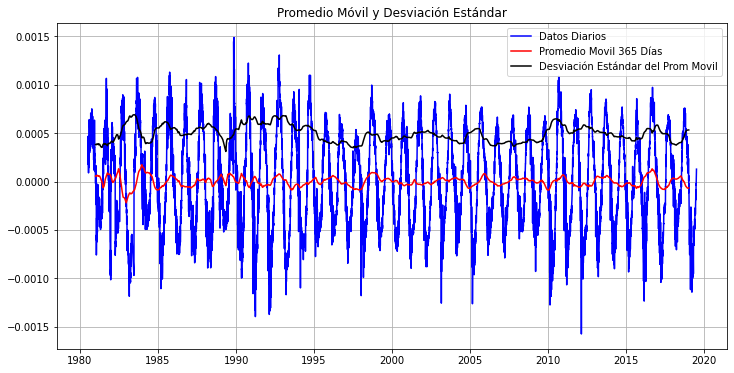

Resultados de la Prueba de Dickey-Fuller
Test Estadistco                  -1.135538e+01
p-value                           9.763779e-21
#Lag's usados                     4.200000e+01
Número de observaciones usadas    1.420300e+04
Critical Value (1%)              -3.430811e+00
Critical Value (5%)              -2.861744e+00
Critical Value (10%)             -2.566878e+00
dtype: float64


In [191]:
# Se hace la prueba de estacionaridad para la diferencia entre la serie en log y el promedio:

ts_test_log_prom_diff = ts_test_log - prom
ts_test_log_prom_diff.dropna(inplace=True)
prueba_est(ts_test_log_prom_diff)

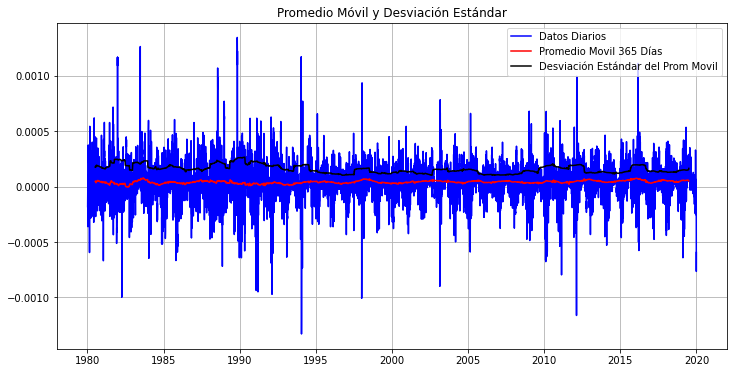

Resultados de la Prueba de Dickey-Fuller
Test Estadistco                  -1.171651e+01
p-value                           1.446943e-21
#Lag's usados                     4.200000e+01
Número de observaciones usadas    1.456000e+04
Critical Value (1%)              -3.430799e+00
Critical Value (5%)              -2.861739e+00
Critical Value (10%)             -2.566876e+00
dtype: float64


In [192]:
# Ahora, se tomará una nueva serie derviando con el comando shift y se probará la estacionalidad de esta:
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
ts_test_log_diff.dropna(inplace=True)
prueba_est(ts_test_log_diff)

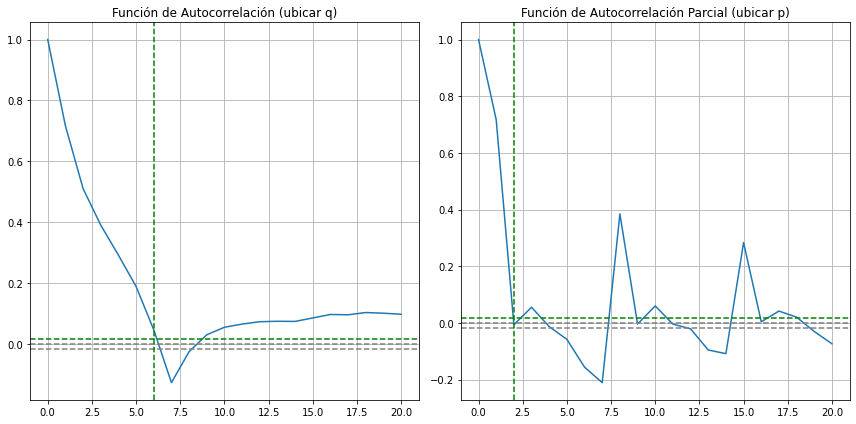

In [193]:
# Es momento ahora de utilizar ARIMA para hacer predicciones. Se utiliza la ultima serie que creamos para ello.
# Se utilizan las funciones ACF y PACF para obtener los parametros de ARIMA (p y q)

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')

# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')

plt.axvline(x=6, linestyle='--', color='green')
plt.grid()
plt.title('Función de Autocorrelación (ubicar q)')

# Gráfica de PACF (Partial Autocorrelation Function)

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')

# Graficamos unas líneas verticales como referencias 

plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Función de Autocorrelación Parcial (ubicar p)')

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14609
Model:                 ARIMA(2, 1, 0)   Log Likelihood              116098.859
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -232189.718
Time:                        06:15:44   BIC                        -232159.360
Sample:                    01-02-1980   HQIC                       -232179.632
                         - 12-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.788e-06   5.33e-07     10.851      0.000    4.74e-06    6.83e-06
ar.L1.D.CO2    -0.1522      0.008    -18.682      0.000      -0.168      -0.136
ar.L2.D.CO2    -0.1753      0.008    -21.511    

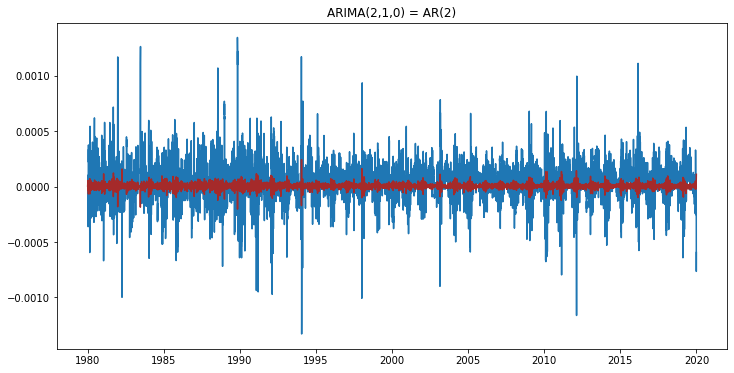

In [194]:
# q=6 y p=2
# Con esto hay que proceder a aplicar ARIMA
# Primero el modelo AR(p)

model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14609
Model:                 ARIMA(0, 1, 6)   Log Likelihood              115820.123
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -231624.247
Time:                        06:15:47   BIC                        -231563.532
Sample:                    01-02-1980   HQIC                       -231604.076
                         - 12-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.815e-06   2.44e-07     23.850      0.000    5.34e-06    6.29e-06
ma.L1.D.CO2    -0.1786      0.009    -20.393      0.000      -0.196      -0.161
ma.L2.D.CO2    -0.2081      0.008    -24.684    

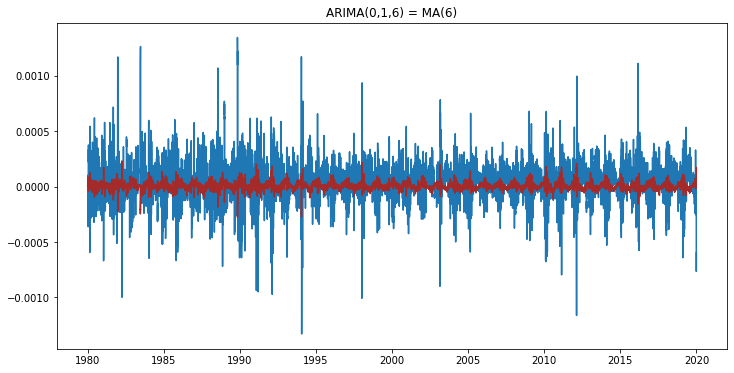

In [195]:
# Ahora el Modelo MA(q)
model = ARIMA(ts_test_log, order=(0,1,6), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,6) = MA(6)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14609
Model:                 ARIMA(2, 1, 6)   Log Likelihood              116209.927
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -232399.855
Time:                        06:16:01   BIC                        -232323.961
Sample:                    01-02-1980   HQIC                       -232374.642
                         - 12-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.795e-06   4.18e-07     13.861      0.000    4.98e-06    6.61e-06
ar.L1.D.CO2     0.3648        nan        nan        nan         nan         nan
ar.L2.D.CO2    -0.6854      0.094     -7.319    

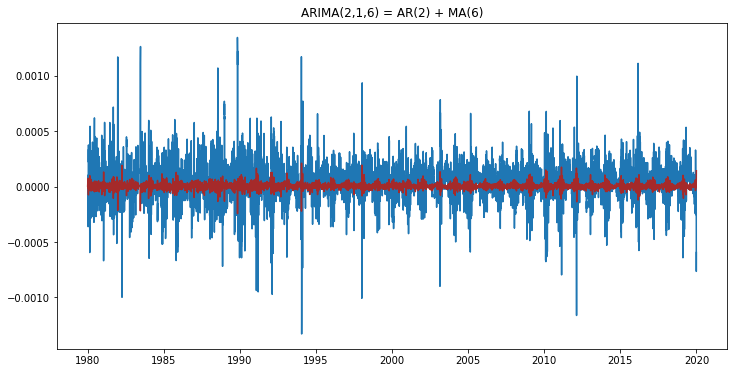

In [196]:
# Modelo ARIMA(p,d,q)
model = ARIMA(ts_test_log, order=(2,1,6), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,6) = AR(2) + MA(6)')
print(results_ARIMA.summary())

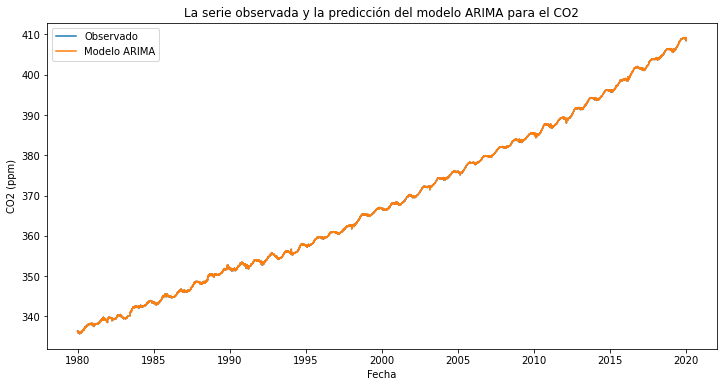

In [197]:
# al tener el menor AIC, se trabaja con este ultimo (ARIMA)
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
predictions_ARIMA = 10**(predictions_ARIMA_log)

plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('CO2 (ppm)')
plt.title('La serie observada y la predicción del modelo ARIMA para el CO2')
plt.legend(loc='best');


In [198]:
# Se calcula el RMSE
RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 0.018899244271053547


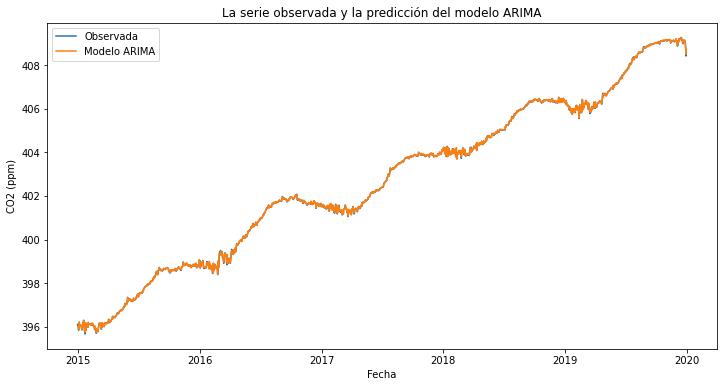

In [201]:
# Por ultimo,veamos los ultimos 5 años del modelo ARIMA y lo observado.
# Considerando que hubo 2 años bisiestos
ts_test_last = ts_test.tail(1827)
predictions_ARIMA_last = predictions_ARIMA.tail(1825)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('CO2 (ppm)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

